In [533]:
import pandas as pd
import numpy as np
import random

import glob

import matplotlib.pyplot as plt
import seaborn as sns

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

from apyori import apriori

from kmodes.kmodes import KModes

In [532]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [158]:
#Reading the datasets
readAccident = pd.read_csv('/Users/nishigandha/PycharmProjects/BigData/Accident_Information.csv',low_memory=False)
#print(readAccident.head(5))
readVehicles = pd.read_csv('/Users/nishigandha/PycharmProjects/BigData/Vehicle_Information.csv',encoding='latin1')
#print(readVehicles.head(5))

In [159]:
#Shape of the data
print('The Accident.csv file has {} rows and {} columns'.format(len(readAccident), len(readAccident.columns)))
print('The Vehicle.csv file has {} rows and {} columns'.format(len(readVehicles), len(readVehicles.columns)))

The Accident.csv file has 2047256 rows and 34 columns
The Vehicle.csv file has 2177205 rows and 24 columns


In [160]:
#Accident.csv PreProcessing
#Keeping the columns which are considered with the analysis
newAccident = readAccident.drop(['1st_Road_Class','1st_Road_Number','2nd_Road_Class','2nd_Road_Number','Carriageway_Hazards',
                                'Did_Police_Officer_Attend_Scene_of_Accident','Junction_Control','Junction_Detail'
                                ], axis=1)
#print(newAccident.head(5))

In [161]:
#As the column name Light_Conditions has variety of values so changing the values
#Eg it has Darkness - lights lit, Darkness -ligtning unknown so changing it to lit, No lights
newAccident = newAccident.replace('Darkness - lights lit','Lights Lit')
newAccident = newAccident.replace('Darkness - lighting unknown','Lighting Unknown')
newAccident = newAccident.replace('Darkness - lights unlit','lights Unlit')
newAccident = newAccident.replace('Darkness - no lighting','No Lights')
#print(newAccident['Light_Conditions'])

In [162]:
#replacing Data missing or out of range for road conditions like oil or disel with Other
newAccident = newAccident.replace({'Road_Surface_Conditions':['Data missing or out of range','Other']})


In [163]:
newAccident = newAccident.replace({'Special_Conditions_at_Site':['Data missing or out of range','Other']})

In [164]:
newAccident = newAccident.replace({'Weather_Conditions':['Unknown','Other']})
newAccident = newAccident.replace({'Weather_Conditions':['Data missing or out of range','Other']})
newAccident = newAccident.replace({'Weather_Conditions':['Fine + high winds','Fine with high winds']})
newAccident = newAccident.replace({'Weather_Conditions':['Raining + high winds','Raining with high winds']})
newAccident = newAccident.replace({'Weather_Conditions':['Snowing + high winds','Snowing with high winds']})

In [165]:
#The date format is not properly stored. It is in object format and thus converting it to proper format
newAccident['Date']= pd.to_datetime(newAccident['Date'], format="%Y-%m-%d")

In [228]:
#Early Morning Traffic from 5am to 9am (5am to 9am)
#Working hour traffic from 9am to 4pm (9am to 16pm)
#Mid-Day traffic from 4pm to 7pm (16pm to 19pm)
#Evening traffic from 7pm to 11pm (18pm to 23pm)
#Late-Night traffic from 11pm to 5am (23pm to 5am)

# The time column is in object format so converting into appropriate format and extracting the hours
# slice first and second string from time column
newAccident['Hour'] = newAccident['Time'].str[0:2]

# convert new column to numeric datetype
newAccident['Hour'] = pd.to_numeric(newAccident['Hour'])

# drop null values in our new column
newAccident = newAccident.dropna(subset=['Hour'])

# cast to integer values
newAccident['Hour'] = newAccident['Hour'].astype('int')

# define a function that turns the hours into daytime groups
def traffic_zone(hour):
   if hour >= 5 and hour < 10:
       return "Early Morning Traffic from (5am to 9am) or (5am to 9am)"
   elif hour >= 10 and hour < 15:
       return "Working hour traffic from (9am to 4pm) or (9am to 16pm)"
   elif hour >= 15 and hour < 19:
       return "Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm) "
   elif hour >= 19 and hour < 23:
       return "Evening traffic from (7pm to 11pm) or (18pm to 23pm)"
   else:
       return "Late-Night traffic from (11pm to 5am) or (23pm to 5am)"
   

newAccident['Traffic_Zones'] = newAccident['Hour'].apply(traffic_zone)


In [229]:
print('Proportion of Missing Values in Accidents Table:',
     round(newAccident.isna().sum().sum()/len(newAccident),3), '%')

Proportion of Missing Values in Accidents Table: 0.074 %


In [168]:
newAccident.tail(10)

,Accident_Index,Accident_Severity,Date,Day_of_Week,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,...,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland,Hour,Traffic_Zones
2047246,2017984119017,Serious,2017-11-02,Thursday,55.002970,Daylight,Dumfries and Galloway,Dumfries & Galloway,323124.0,568262.0,...,Single carriageway,None,60.0,16:30,Rural,Fine no high winds,2017,Yes,16,Mid-Day traffic from (4pm to 7pm) or (16pm to ...
2047247,2017984119217,Slight,2017-11-06,Monday,55.201839,Daylight,Dumfries and Galloway,Dumfries & Galloway,305060.0,590748.0,...,Single carriageway,Roadworks,60.0,11:10,Rural,Fine no high winds,2017,Yes,11,Working hour traffic from (9am to 4pm) or (9am...
2047248,2017984119917,Serious,2017-11-24,Friday,55.320807,No Lights,Dumfries and Galloway,Dumfries & Galloway,306995.0,603951.0,...,Dual carriageway,None,70.0,07:30,Rural,Fog or mist,2017,Yes,7,Early Morning Traffic from (5am to 9am) or (5a...
2047249,2017984120017,Slight,2017-08-15,Tuesday,55.123420,Daylight,Dumfries and Galloway,Dumfries & Galloway,308939.0,581937.0,...,Single carriageway,None,60.0,13:05,Rural,Fine no high winds,2017,Yes,13,Working hour traffic from (9am to 4pm) or (9am...
2047250,2017984120717,Serious,2017-12-14,Thursday,55.078831,Daylight,Dumfries and Galloway,Dumfries & Galloway,336578.0,576494.0,...,Single carriageway,None,60.0,15:15,Rural,Fine no high winds,2017,Yes,15,Working hour traffic from (9am to 4pm) or (9am...
2047251,2017984121017,Slight,2017-12-17,Sunday,55.311793,Daylight,Dumfries and Galloway,Dumfries & Galloway,308024.0,602926.0,...,Dual carriageway,None,70.0,11:30,Rural,Other,2017,Yes,11,Working hour traffic from (9am to 4pm) or (9am...
2047252,2017984121217,Slight,2017-12-15,Friday,54.994285,Daylight,Dumfries and Galloway,Dumfries & Galloway,331826.0,567154.0,...,Single carriageway,None,20.0,13:00,Urban,Fine no high winds,2017,Yes,13,Working hour traffic from (9am to 4pm) or (9am...
2047253,2017984121717,Slight,2017-12-18,Monday,55.053767,Daylight,Dumfries and Galloway,Dumfries & Galloway,321809.0,573939.0,...,Dual carriageway,None,70.0,13:30,Rural,Fine no high winds,2017,Yes,13,Working hour traffic from (9am to 4pm) or (9am...
2047254,2017984122317,Slight,2017-07-18,Tuesday,55.326392,Daylight,Dumfries and Galloway,Dumfries & Galloway,310467.0,604501.0,...,Single carriageway,None,60.0,18:00,Rural,Fine no high winds,2017,Yes,18,Mid-Day traffic from (4pm to 7pm) or (16pm to ...
2047255,2017984122617,Serious,2017-12-20,Wednesday,54.989905,Daylight,Dumfries and Galloway,Dumfries & Galloway,318705.0,566886.0,...,Single carriageway,None,40.0,13:00,Rural,Fog or mist,2017,Yes,13,Working hour traffic from (9am to 4pm) or (9am...


In [169]:
#Vehicle.csv PreProcessing
#Keeping the columns which are considered with the analysis
newVehicle = readVehicles.drop(['Engine_Capacity_.CC.','Journey_Purpose_of_Driver','Towing_and_Articulation','Vehicle_Leaving_Carriageway',
                               'Vehicle_Manoeuvre','Vehicle_Reference','Was_Vehicle_Left_Hand_Drive','X1st_Point_of_Impact','Junction_Location','Driver_IMD_Decile','model','Age_of_Vehicle'], axis=1)

In [170]:
newVehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177205 entries, 0 to 2177204
Data columns (total 12 columns):
Accident_Index                      object
Age_Band_of_Driver                  object
Driver_Home_Area_Type               object
Hit_Object_in_Carriageway           object
Hit_Object_off_Carriageway          object
make                                object
Propulsion_Code                     object
Sex_of_Driver                       object
Skidding_and_Overturning            object
Vehicle_Location.Restricted_Lane    float64
Vehicle_Type                        object
Year                                int64
dtypes: float64(1), int64(1), object(10)
memory usage: 199.3+ MB


In [171]:
newVehicle[newVehicle['Age_Band_of_Driver']=='11 - 15']

,Accident_Index,Age_Band_of_Driver,Driver_Home_Area_Type,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Vehicle_Location.Restricted_Lane,Vehicle_Type,Year
2361,200401EO01882,11 - 15,Data missing or out of range,None,None,ROVER,Petrol,Male,None,0.0,109,2004
5174,200401KO00354,11 - 15,Urban area,Parked vehicle,None,TOYOTA,Petrol,Female,None,0.0,109,2004
5405,200401LX00149,11 - 15,Data missing or out of range,None,None,PIAGGIO,Petrol,Male,None,0.0,Motorcycle 125cc and under,2004
8486,200401RG40045,11 - 15,Data missing or out of range,None,None,PIAGGIO,NaN,Male,None,0.0,Motorcycle 125cc and under,2004
9190,200401SX00057,11 - 15,Data missing or out of range,None,None,HONDA,Petrol,Male,None,0.0,Motorcycle 50cc and under,2004
...,...,...,...,...,...,...,...,...,...,...,...,...
2175112,201697QB00407,11 - 15,Urban area,None,None,NaN,NaN,Male,None,0.0,Pedal cycle,2016
2175229,201697QB03808,11 - 15,Urban area,None,None,NaN,NaN,Male,None,0.0,Pedal cycle,2016
2175265,201697QB04509,11 - 15,Urban area,None,None,NaN,NaN,Female,None,0.0,Pedal cycle,2016
2176134,201697UC01607,11 - 15,Small town,None,None,NaN,NaN,Male,None,0.0,Pedal cycle,2016


In [172]:
newVehicle.Age_Band_of_Driver.unique()

array(['26 - 35', '66 - 75', '36 - 45', '46 - 55', '21 - 25',
       'Data missing or out of range', '16 - 20', '56 - 65', 'Over 75',
       '11 - 15', '6 - 10', '0 - 5'], dtype=object)

In [173]:
newVehicle['Age_Band_of_Driver'] = newVehicle['Age_Band_of_Driver'].replace('Data missing or out of range','46 - 55')
newVehicle['Age_Band_of_Driver'] = newVehicle['Age_Band_of_Driver'].replace('Over 75','76 - 95')

In [174]:
newVehicle['Age_Band_of_Driver'] = newVehicle['Age_Band_of_Driver'].replace('11 - 15','26 - 35')
newVehicle['Age_Band_of_Driver'] = newVehicle['Age_Band_of_Driver'].replace('6 - 10','26 - 35')

In [175]:
newVehicle['Driver_Home_Area_Type'] = newVehicle['Driver_Home_Area_Type'].replace('Data missing or out of range','Miscellaneous area')
newVehicle['Propulsion_Code'] = newVehicle['Propulsion_Code'].replace('NaN','Other')


In [176]:
#Shape of the data
print('The Accident.csv file has {} rows and {} columns'.format(len(newAccident), len(newAccident.columns)))
print('The Vehicle.csv file has {} rows and {} columns'.format(len(newVehicle), len(newVehicle.columns)))

The Accident.csv file has 2047100 rows and 28 columns
The Vehicle.csv file has 2177205 rows and 12 columns


In [376]:
#Combining the accident and vehicle files
#combination = pd.merge(newAccident,newVehicle,on='Accident_Index')
combination = pd.merge(left=newAccident, right=newVehicle, how='right', left_on='Accident_Index', right_on='Accident_Index')

In [377]:
print('The combination.csv file has {} rows and {} columns'.format(len(combination), len(combination.columns)))

The combination.csv file has 2177205 rows and 39 columns


In [378]:
combination[combination['Age_Band_of_Driver'] == '76 - 95'].count()

Accident_Index                             54236
Accident_Severity                          51992
Date                                       51992
Day_of_Week                                51992
Latitude                                   51987
Light_Conditions                           51992
Local_Authority_(District)                 51992
Local_Authority_(Highway)                  51992
Location_Easting_OSGR                      51987
Location_Northing_OSGR                     51987
Longitude                                  51987
LSOA_of_Accident_Location                  48235
Number_of_Casualties                       51992
Number_of_Vehicles                         51992
Pedestrian_Crossing-Human_Control          51984
Pedestrian_Crossing-Physical_Facilities    51979
Police_Force                               51992
Road_Surface_Conditions                    51992
Road_Type                                  51992
Special_Conditions_at_Site                 51992
Speed_limit         

In [379]:
Random_Age05 = pd.DataFrame(np.random.randint(0,5,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age']=Random_Age05['A'].where(combination['Age_Band_of_Driver']=='0 - 5')

In [380]:
Random_Age1620 = pd.DataFrame(np.random.randint(16,20,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age1620['A'].where(combination['Age_Band_of_Driver']=='16 - 20'))

In [381]:
Random_Age2125 = pd.DataFrame(np.random.randint(16,20,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age2125['A'].where(combination['Age_Band_of_Driver']=='21 - 25'))

In [382]:
Random_Age2635 = pd.DataFrame(np.random.randint(26,35,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age2635['A'].where(combination['Age_Band_of_Driver']=='26 - 35'))

In [383]:
Random_Age3645 = pd.DataFrame(np.random.randint(36,45,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age3645['A'].where(combination['Age_Band_of_Driver']=='36 - 45'))

In [384]:
Random_Age4655 = pd.DataFrame(np.random.randint(46,55,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age4655['A'].where(combination['Age_Band_of_Driver']=='46 - 55'))

In [385]:
Random_Age5665 = pd.DataFrame(np.random.randint(56,65,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age5665['A'].where(combination['Age_Band_of_Driver']=='56 - 65'))

In [386]:
Random_Age6675 = pd.DataFrame(np.random.randint(66,75,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age6675['A'].where(combination['Age_Band_of_Driver']=='66 - 75'))

In [387]:
Random_Age7695 = pd.DataFrame(np.random.randint(76,95,size=(len(combination), 1)), columns=list('A'))
combination['Random_Age'].update(Random_Age7695['A'].where(combination['Age_Band_of_Driver']=='76 - 95'))

In [388]:
combination[['Age_Band_of_Driver','Random_Age']].head(50)

,Age_Band_of_Driver,Random_Age
0,36 - 45,37.0
1,26 - 35,31.0
2,46 - 55,51.0
3,46 - 55,51.0
4,46 - 55,51.0
5,26 - 35,33.0
6,26 - 35,30.0
7,36 - 45,37.0
8,66 - 75,72.0
9,26 - 35,33.0


In [389]:
combination[['Age_Band_of_Driver','Random_Age']].isna()

,Age_Band_of_Driver,Random_Age
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
2177200,False,False
2177201,False,False
2177202,False,False
2177203,False,False


In [390]:
combination.head(10)

,Accident_Index,Accident_Severity,Date,Day_of_Week,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,...,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Vehicle_Location.Restricted_Lane,Vehicle_Type,Year_y,Random_Age
0,200501BS00002,Slight,2005-01-05,Wednesday,51.520075,Lights Lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,...,None,None,DENNIS,Heavy oil,Male,None,0.0,Bus or coach (17 or more pass seats),2005,37.0
1,200501BS00003,Slight,2005-01-06,Thursday,51.525301,Lights Lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,...,Parked vehicle,None,DENNIS,Heavy oil,Male,None,0.0,Bus or coach (17 or more pass seats),2005,31.0
2,200501BS00004,Slight,2005-01-07,Friday,51.482442,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,...,None,None,NISSAN,Petrol,Female,None,0.0,Car,2005,51.0
3,200501BS00005,Slight,2005-01-10,Monday,51.495752,Lighting Unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,...,Kerb,None,HONDA,Petrol,Male,Skidded,0.0,Motorcycle 125cc and under,2005,51.0
4,200501BS00006,Slight,2005-01-11,Tuesday,51.515540,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.0,181160.0,...,None,None,AUDI,Petrol,Male,None,0.0,Car,2005,51.0
5,200501BS00006,Slight,2005-01-11,Tuesday,51.515540,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.0,181160.0,...,None,None,PIAGGIO,Petrol,Female,None,0.0,Motorcycle 125cc and under,2005,33.0
6,200501BS00007,Slight,2005-01-13,Thursday,51.512695,Lights Lit,Kensington and Chelsea,Kensington and Chelsea,524220.0,180830.0,...,Parked vehicle,None,AUDI,NaN,Male,None,0.0,Motorcycle 125cc and under,2005,30.0
7,200501BS00007,Slight,2005-01-13,Thursday,51.512695,Lights Lit,Kensington and Chelsea,Kensington and Chelsea,524220.0,180830.0,...,None,None,MERCEDES,Petrol,Male,None,0.0,Car,2005,37.0
8,200501BS00009,Slight,2005-01-14,Friday,51.502260,Daylight,Kensington and Chelsea,Kensington and Chelsea,525890.0,179710.0,...,None,None,JAGUAR,Petrol,Male,None,0.0,Car,2005,72.0
9,200501BS00012,Slight,2005-01-16,Sunday,51.494902,Lights Lit,Kensington and Chelsea,Kensington and Chelsea,526240.0,178900.0,...,None,None,FORD,Petrol,Male,None,0.0,Car,2005,33.0


In [391]:
combination.to_csv('/Users/nishigandha/PycharmProjects/BigData/Biggest_Data.csv')
#print(readAccident.head(5))

In [248]:
combination[['Age_Band_of_Driver','Random_Age','Number_of_Casualties']].tail(60)

,Age_Band_of_Driver,Random_Age,Number_of_Casualties
2177145,56 - 65,59.0,NaN
2177146,46 - 55,53.0,NaN
2177147,56 - 65,62.0,NaN
2177148,56 - 65,59.0,NaN
2177149,36 - 45,40.0,NaN
2177150,56 - 65,64.0,NaN
2177151,26 - 35,34.0,NaN
2177152,36 - 45,36.0,NaN
2177153,21 - 25,18.0,NaN
2177154,66 - 75,67.0,NaN


In [249]:
combination[['Number_of_Casualties'].unique()

SyntaxError: unexpected EOF while parsing (<ipython-input-249-f61817beafda>, line 1)

In [392]:
combination['Number_of_Casualties'].median()

1.0

In [393]:
combination['Number_of_Casualties'].fillna(1, inplace=True)

In [394]:
combination['Age_Band_of_Driver'].value_counts()

46 - 55    519814
26 - 35    455070
36 - 45    435686
21 - 25    238765
56 - 65    206181
16 - 20    175874
66 - 75     91454
76 - 95     54236
0 - 5         125
Name: Age_Band_of_Driver, dtype: int64

In [200]:
# #number_of_casualties
#combination[['Age_Band_of_Driver','Number_of_Casualties']].value_counts()
# #number_of_casualties
combination['Number_of_Casualties'].value_counts()

1.0     1593829
2.0      385293
3.0      121653
4.0       45416
5.0       17781
6.0        7293
7.0        2658
8.0        1250
9.0         612
10.0        373
11.0        241
12.0        150
13.0        124
14.0         74
16.0         72
70.0         53
36.0         41
15.0         39
17.0         37
26.0         31
19.0         27
21.0         21
18.0         19
22.0         15
29.0         10
23.0          8
27.0          8
87.0          7
24.0          7
25.0          7
43.0          5
35.0          5
20.0          5
40.0          5
38.0          5
42.0          5
34.0          3
41.0          3
33.0          2
93.0          2
32.0          2
45.0          2
46.0          2
51.0          2
58.0          2
63.0          2
54.0          1
62.0          1
68.0          1
28.0          1
Name: Number_of_Casualties, dtype: int64

,Age_Band_of_Driver,mean
0,0 - 5,1.024000
1,16 - 20,1.481823
2,21 - 25,1.475867
3,26 - 35,1.458735
4,36 - 45,1.468850
5,46 - 55,1.388519
6,56 - 65,1.465602
7,66 - 75,1.483122
8,76 - 95,1.471496


In [95]:
for x in combination['Age_Band_of_Driver']:
    if x == '0 - 5':
        combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.024000).where(combination['Age_Band_of_Driver']=='0 - 5'))
    elif x == '16 - 20':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.481823).where(combination['Age_Band_of_Driver']=='16 - 20'))
    elif x == '21 - 25':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.475867).where(combination['Age_Band_of_Driver']=='21 - 25'))
    elif x == '26 - 35':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.458735).where(combination['Age_Band_of_Driver']=='26 - 35'))
    elif x == '36 - 45':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.468850).where(combination['Age_Band_of_Driver']=='36 - 45'))
    elif x == '46 - 55':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.388519).where(combination['Age_Band_of_Driver']=='46 - 55'))
    elif x == '56 - 65':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.465602).where(combination['Age_Band_of_Driver']=='56 - 65'))
    elif x == '66 - 75':
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.483122).where(combination['Age_Band_of_Driver']=='66 - 75'))
    else:
         combination['Number_of_Casualties'].update(combination['Number_of_Casualties'].replace(to_replace = np.nan, value =1.471496).where(combination['Age_Band_of_Driver']=='76 - 95'))

    


    

KeyboardInterrupt: 

In [201]:
combination.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177205 entries, 0 to 2177204
Data columns (total 40 columns):
Accident_Index                             object
Accident_Severity                          object
Date                                       datetime64[ns]
Day_of_Week                                object
Latitude                                   float64
Light_Conditions                           object
Local_Authority_(District)                 object
Local_Authority_(Highway)                  object
Location_Easting_OSGR                      float64
Location_Northing_OSGR                     float64
Longitude                                  float64
LSOA_of_Accident_Location                  object
Number_of_Casualties                       float64
Number_of_Vehicles                         float64
Pedestrian_Crossing-Human_Control          float64
Pedestrian_Crossing-Physical_Facilities    float64
Police_Force                               object
Road_Surface_Conditio

In [395]:
combination['Random_Age']=combination['Random_Age'].astype(int)

In [396]:
combination['Number_of_Casualties']=combination['Number_of_Casualties'].astype(int)

In [397]:
combination[['Age_Band_of_Driver','Random_Age','Number_of_Casualties']].head(60)

,Age_Band_of_Driver,Random_Age,Number_of_Casualties
0,36 - 45,37,1
1,26 - 35,31,1
2,46 - 55,51,1
3,46 - 55,51,1
4,46 - 55,51,1
5,26 - 35,33,1
6,26 - 35,30,1
7,36 - 45,37,1
8,66 - 75,72,2
9,26 - 35,33,1


In [398]:
combination.to_csv('/Users/nishigandha/PycharmProjects/BigData/Biggest_Data.csv')

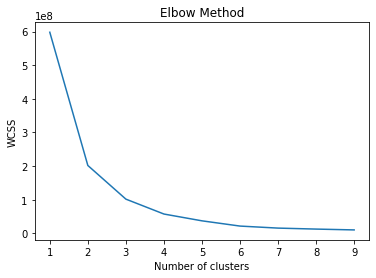

In [205]:
X= combination[['Random_Age','Number_of_Casualties']]
wcss = []
for i in range(1,10):
   kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=2177204, n_init=10, random_state=0)
   kmeans.fit(X)
   wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
# Plot the data
A = combination[['Random_Age']]
B = combination[['Number_of_Casualties']]
# Getting the values and plotting it
f1 = A.values
f2 = B.values
plt.xlabel("Age")
plt.ylabel("Casulaties")
plt.title('Visualization of raw data')
X = np.array(list(zip(f1, f2)))
plt.scatter(f1, f2, c='blue', s=5)

In [209]:
X= combination[['Random_Age','Number_of_Casualties']]
x = X.iloc[:, [0,1]].values
kmeans = KMeans(n_clusters=3)

In [210]:
y_kmeans = kmeans.fit_predict(x)
print(y_kmeans)

kmeans.cluster_centers_

[1 0 1 ... 1 1 1]


array([[24.03859127,  1.44183603],
       [45.6838935 ,  1.40220184],
       [67.1772756 ,  1.44862814]])

In [213]:
col=[]
for i in range (len(y_kmeans)):
   if y_kmeans[i]==0: col.append("red")
   elif y_kmeans[i]==1: col.append("blue")
   elif y_kmeans[i]==2: col.append("green")

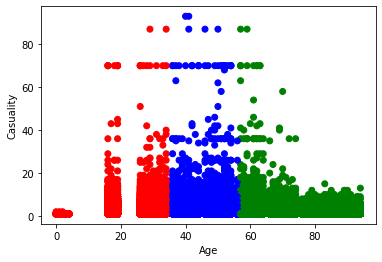

In [218]:
#plt.scatter(x[:,0],x[:,1],c=y_kmeans,cmap='rainbow')
plt.scatter(x[:,0],x[:,1],color=col)
plt.xlabel("Age")
plt.ylabel("Casuality")
plt.show()

In [322]:
Y= combination[['Random_Age','Number_of_Casualties']]
y = X.iloc[:, [0,1]].values

In [323]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [281]:
Kmean.cluster_centers_

array([[24.03859127,  1.44183603],
       [45.6838935 ,  1.40220184],
       [67.1772756 ,  1.44862814]])

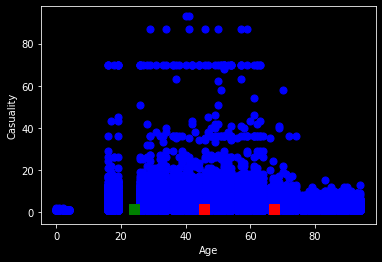

In [324]:
plt.scatter(y[ : , 0], y[ : , 1], s =50, c='b')
plt.scatter(24.03859127, 1.44183603, s=100, c='g', marker='s')
plt.scatter(45.6838935, 1.40220184, s=100, c='r', marker='s')
plt.scatter(67.1772756, 1.44862814, s=100, c='r', marker='s')
plt.xlabel("Age")
plt.ylabel("Casuality")
plt.show()

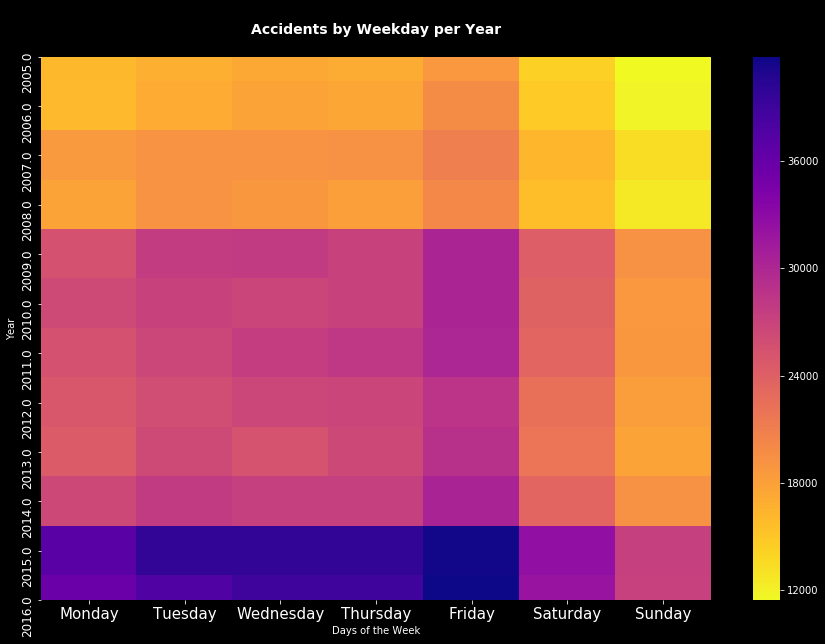

In [223]:
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
accweekday = combination.groupby(['Year_x', 'Day_of_Week']).size()
accweekday = accweekday.rename_axis(['year', 'day_of_week'])\
                               .unstack('day_of_week')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(15,10))
plt.style.use('dark_background')
sns.heatmap(accweekday, cmap='plasma_r')
plt.title('\nAccidents by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('Days of the Week')
plt.ylabel('Year')
plt.savefig('accidentsbyweekdayperyear.png')
plt.show()

In [226]:
combination.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177205 entries, 0 to 2177204
Data columns (total 40 columns):
Accident_Index                             object
Accident_Severity                          object
Date                                       datetime64[ns]
Day_of_Week                                object
Latitude                                   float64
Light_Conditions                           object
Local_Authority_(District)                 object
Local_Authority_(Highway)                  object
Location_Easting_OSGR                      float64
Location_Northing_OSGR                     float64
Longitude                                  float64
LSOA_of_Accident_Location                  object
Number_of_Casualties                       int64
Number_of_Vehicles                         float64
Pedestrian_Crossing-Human_Control          float64
Pedestrian_Crossing-Physical_Facilities    float64
Police_Force                               object
Road_Surface_Conditions

In [225]:
combination['Date']= pd.to_datetime(combination['Date'], format="%Y-%m-%d")

combination.head()

In [261]:
combination.shape

(2177205, 40)

In [263]:
A = pd.merge(left=newAccident, right=newVehicle, how='right', left_on='Accident_Index', right_on='Accident_Index')


In [291]:
A=combination[['Random_Age','Number_of_Casualties','Year_x','Weather_Conditions']]

In [292]:
A.to_csv('/Users/nishigandha/PycharmProjects/BigData/A.csv')

In [499]:
def weather(weather):
    if weather == 'Fine no high winds' :
        return "1"
    elif weather == 'Fine with high winds':
        return "2"
    elif weather == 'Raining with high winds':
        return "3"
    elif weather == 'Raining no high winds':
        return "4"
    elif weather == 'Snowing with high winds':
        return "5"
    elif weather == 'Snowing no high winds':
        return "6"
    else:
        return "7"

In [505]:

#apply function   
#time of day function
combination['Weather_ConditionN']= combination['Weather_Conditions'].apply(weather)

In [506]:

combination[['Weather_Conditions', 'Weather_ConditionN']].tail(10)

,Weather_Conditions,Weather_ConditionN
2177195,NaN,7
2177196,NaN,7
2177197,NaN,7
2177198,NaN,7
2177199,NaN,7
2177200,NaN,7
2177201,NaN,7
2177202,NaN,7
2177203,NaN,7
2177204,NaN,7


In [597]:
combination.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177205 entries, 0 to 2177204
Data columns (total 41 columns):
Accident_Index                             object
Accident_Severity                          object
Date                                       datetime64[ns]
Day_of_Week                                object
Latitude                                   float64
Light_Conditions                           object
Local_Authority_(District)                 object
Local_Authority_(Highway)                  object
Location_Easting_OSGR                      float64
Location_Northing_OSGR                     float64
Longitude                                  float64
LSOA_of_Accident_Location                  object
Number_of_Casualties                       int64
Number_of_Vehicles                         float64
Pedestrian_Crossing-Human_Control          float64
Pedestrian_Crossing-Physical_Facilities    float64
Police_Force                               object
Road_Surface_Conditions

In [637]:
Y= combination[['Age_Band_of_Driver','Random_Age','Number_of_Casualties','Weather_ConditionN','Year_x','Accident_Severity','Sex_of_Driver',
                'Speed_limit','Day_of_Week','Traffic_Zones','Road_Surface_Conditions']]
#y = Y.iloc[:, [0,2]].values

In [646]:
Y['accident_seriousness'].fillna('Serious', inplace=True)

In [636]:
Y['Traffic_Zones'].unique()

array(['Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm) ',
       'Late-Night traffic from (11pm to 5am) or (23pm to 5am)',
       'Working hour traffic from (9am to 4pm) or (9am to 16pm)',
       'Evening traffic from (7pm to 11pm) or (18pm to 23pm)',
       'Early Morning Traffic from (5am to 9am) or (5am to 9am)',
       'Wet or damp'], dtype=object)

In [638]:
Y['accident_seriousness'] = Y['Accident_Severity']
Y['accident_seriousness'] = Y['accident_seriousness'].replace(to_replace="Slight", 
                                                                value="Not Serious")
Y['accident_seriousness'] = Y['accident_seriousness'].replace(to_replace="Serious",
                                                                value="Serious")
Y['accident_seriousness'] = Y['accident_seriousness'].replace(to_replace="Fatal", 
                                                                value="Serious")
Y['accident_seriousness'] = Y['accident_seriousness'].replace(to_replace="NaN", 
                                                                value="Not Serious")

In [639]:
Y['Year_x'].median()
Y['Year_x'].fillna(2012, inplace=True)

In [644]:
Y['Day_of_Week'].fillna('Friday', inplace=True)

In [631]:
Y['Sex_of_Driver']=Y['Sex_of_Driver'].replace('Data missing or out of range','Male')

In [640]:
Y['Road_Surface_Conditions'].fillna('Wet or damp',inplace=True)

In [641]:
Y['Traffic_Zones'].fillna('Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm)',inplace=True)

In [642]:
Y['Speed_limit'].median()
Y['Speed_limit'].fillna(30, inplace=True)

In [650]:
Y['Sex_of_Driver']=Y['Sex_of_Driver'].replace('Data missing or out of range','Male')

In [651]:
Y

,Age_Band_of_Driver,Random_Age,Number_of_Casualties,Weather_ConditionN,Year_x,Accident_Severity,Sex_of_Driver,Speed_limit,Day_of_Week,Traffic_Zones,Road_Surface_Conditions,accident_seriousness
0,36 - 45,37,1,1,2005.0,Slight,Male,30.0,Wednesday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Dry,Not Serious
1,26 - 35,31,1,1,2005.0,Slight,Male,30.0,Thursday,Late-Night traffic from (11pm to 5am) or (23pm...,Dry,Not Serious
2,46 - 55,51,1,1,2005.0,Slight,Female,30.0,Friday,Working hour traffic from (9am to 4pm) or (9am...,Dry,Not Serious
3,46 - 55,51,1,1,2005.0,Slight,Male,30.0,Monday,Evening traffic from (7pm to 11pm) or (18pm to...,Wet or damp,Not Serious
4,46 - 55,51,1,4,2005.0,Slight,Male,30.0,Tuesday,Working hour traffic from (9am to 4pm) or (9am...,Wet or damp,Not Serious
...,...,...,...,...,...,...,...,...,...,...,...,...
2177200,36 - 45,41,1,7,2012.0,NaN,Female,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp,Serious
2177201,56 - 65,60,1,7,2012.0,NaN,Male,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp,Serious
2177202,46 - 55,54,1,7,2012.0,NaN,Female,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp,Serious
2177203,46 - 55,52,1,7,2012.0,NaN,Female,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp,Serious


<bound method Series.drop of 0          Slight
1          Slight
2          Slight
3          Slight
4          Slight
            ...  
2177200       NaN
2177201       NaN
2177202       NaN
2177203       NaN
2177204       NaN
Name: Accident_Severity, Length: 2177205, dtype: object>

In [652]:
frame = Y[['Age_Band_of_Driver','Random_Age','Number_of_Casualties','Weather_ConditionN','Year_x','Sex_of_Driver',
                'Speed_limit','Day_of_Week','Traffic_Zones','Road_Surface_Conditions']]

In [653]:
frame

,Age_Band_of_Driver,Random_Age,Number_of_Casualties,Weather_ConditionN,Year_x,Sex_of_Driver,Speed_limit,Day_of_Week,Traffic_Zones,Road_Surface_Conditions
0,36 - 45,37,1,1,2005.0,Male,30.0,Wednesday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Dry
1,26 - 35,31,1,1,2005.0,Male,30.0,Thursday,Late-Night traffic from (11pm to 5am) or (23pm...,Dry
2,46 - 55,51,1,1,2005.0,Female,30.0,Friday,Working hour traffic from (9am to 4pm) or (9am...,Dry
3,46 - 55,51,1,1,2005.0,Male,30.0,Monday,Evening traffic from (7pm to 11pm) or (18pm to...,Wet or damp
4,46 - 55,51,1,4,2005.0,Male,30.0,Tuesday,Working hour traffic from (9am to 4pm) or (9am...,Wet or damp
...,...,...,...,...,...,...,...,...,...,...
2177200,36 - 45,41,1,7,2012.0,Female,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp
2177201,56 - 65,60,1,7,2012.0,Male,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp
2177202,46 - 55,54,1,7,2012.0,Female,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp
2177203,46 - 55,52,1,7,2012.0,Female,30.0,Friday,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wet or damp


In [ ]:
# "clustering" using kmode algorithm that is designed to handle mixed data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1)
fitClusters_huang = km_huang.fit_predict(frame)
fitClusters_huang

In [589]:
newdf1 = frame.copy().reset_index()
clustersDf = pd.DataFrame(fitClusters_huang)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([newdf1, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)

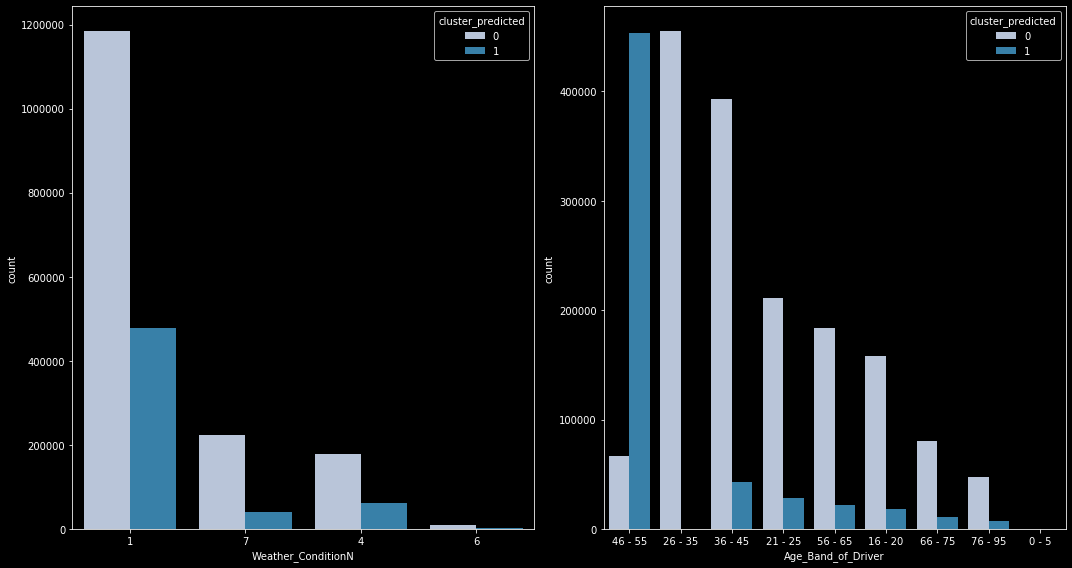

In [596]:
f, axs = plt.subplots(1,2,figsize = (15,8))
sns.countplot(x=combinedDf['Weather_ConditionN'],
              order=combinedDf['Weather_ConditionN'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='Spectral', ax=axs[0])
sns.countplot(x=combinedDf['Age_Band_of_Driver'],
              order=combinedDf['Age_Band_of_Driver'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[1])
plt.tight_layout()
plt.savefig('clusterplot4.png')
plt.show()

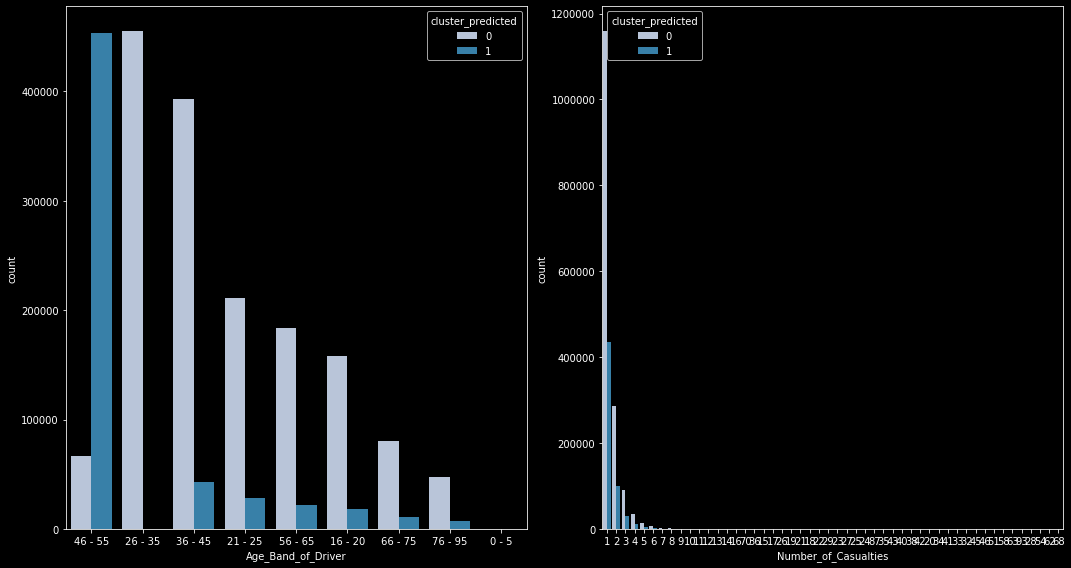

In [593]:
f, axs = plt.subplots(1,2,figsize = (15,8))
sns.countplot(x=combinedDf['Number_of_Casualties'],
              order=combinedDf['Number_of_Casualties'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[1])
sns.countplot(x=combinedDf['Age_Band_of_Driver'],
              order=combinedDf['Age_Band_of_Driver'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[0])
plt.tight_layout()
plt.savefig('clusterplot4.png')
plt.show()

In [514]:
Y.to_csv('/Users/nishigandha/PycharmProjects/BigData/Weather.csv')

In [307]:
Kmean = KMeans(n_clusters=4)
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [308]:
Kmean.cluster_centers_

array([[32.77798514,  1.43547716],
       [68.74729799,  1.45001501],
       [17.49661253,  1.45245489],
       [48.75686592,  1.39219996]])

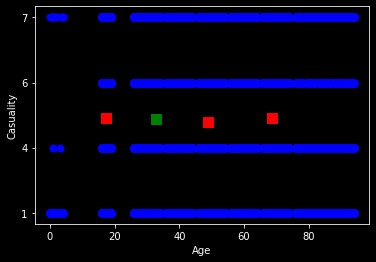

In [314]:
plt.scatter(y[ : , 0], y[ : , 1], s =50, c='b')
plt.scatter(32.77798514, 1.43547716, s=100, c='g', marker='s')
plt.scatter(68.74729799, 1.45001501, s=100, c='r', marker='s')
plt.scatter(17.49661253, 1.45245489, s=100, c='r', marker='s')
plt.scatter(48.75686592, 1.39219996, s=100, c='r', marker='s')
plt.xlabel("Age")
plt.ylabel("Casuality")
plt.show()

In [319]:
B.to_csv('/Users/nishigandha/PycharmProjects/BigData/Weather.csv')

In [401]:
combination.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177205 entries, 0 to 2177204
Data columns (total 40 columns):
Accident_Index                             object
Accident_Severity                          object
Date                                       datetime64[ns]
Day_of_Week                                object
Latitude                                   float64
Light_Conditions                           object
Local_Authority_(District)                 object
Local_Authority_(Highway)                  object
Location_Easting_OSGR                      float64
Location_Northing_OSGR                     float64
Longitude                                  float64
LSOA_of_Accident_Location                  object
Number_of_Casualties                       int64
Number_of_Vehicles                         float64
Pedestrian_Crossing-Human_Control          float64
Pedestrian_Crossing-Physical_Facilities    float64
Police_Force                               object
Road_Surface_Conditions

In [478]:
C=combination[['Accident_Index','Age_Band_of_Driver','Number_of_Casualties','Weather_Conditions',
               'Year_x','Road_Surface_Conditions','Skidding_and_Overturning','Traffic_Zones','Day_of_Week','Random_Age']]




In [479]:
C.isnull()

,Accident_Index,Age_Band_of_Driver,Number_of_Casualties,Weather_Conditions,Year_x,Road_Surface_Conditions,Skidding_and_Overturning,Traffic_Zones,Day_of_Week,Random_Age
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2177200,False,False,False,True,True,True,False,True,True,False
2177201,False,False,False,True,True,True,False,True,True,False
2177202,False,False,False,True,True,True,False,True,True,False
2177203,False,False,False,True,True,True,False,True,True,False


In [480]:
C['Year_x'].median()
C['Year_x'].fillna(2012, inplace=True)

In [481]:
#C['Weather_Conditions'].fillna('Raining + high winds', inplace=True)
C['Weather_Conditions']=C['Weather_Conditions'].replace('Data missing or out of range','Raining + high winds')

In [482]:
C['Road_Surface_Conditions'].fillna('Wet or damp', inplace=True)
C['Road_Surface_Conditions']=C['Road_Surface_Conditions'].replace('Data missing or out of range','Wet or damp')

In [483]:
C['Skidding_and_Overturning']=C['Skidding_and_Overturning'].replace('Data missing or out of range','Skidded')

In [484]:
C['Road_Surface_Conditions'].fillna('Mid-Day traffic from (4pm to 7pm) or (1', inplace=True)C['Traffic_Zones'].fillna('Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm)', inplace=True)

In [485]:
C['Traffic_Zones'].fillna('Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm)', inplace=True)

In [486]:
C['Day_of_Week'].fillna('Friday', inplace=True)

In [487]:
C['Traffic_Zones'].unique()

array(['Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm) ',
       'Late-Night traffic from (11pm to 5am) or (23pm to 5am)',
       'Working hour traffic from (9am to 4pm) or (9am to 16pm)',
       'Evening traffic from (7pm to 11pm) or (18pm to 23pm)',
       'Early Morning Traffic from (5am to 9am) or (5am to 9am)',
       'Mid-Day traffic from (4pm to 7pm) or (16pm to 19pm)'],
      dtype=object)

In [488]:
C.head()

,Accident_Index,Age_Band_of_Driver,Number_of_Casualties,Weather_Conditions,Year_x,Road_Surface_Conditions,Skidding_and_Overturning,Traffic_Zones,Day_of_Week,Random_Age
0,200501BS00002,36 - 45,1,Fine no high winds,2005.0,Dry,None,Mid-Day traffic from (4pm to 7pm) or (16pm to ...,Wednesday,37
1,200501BS00003,26 - 35,1,Fine no high winds,2005.0,Dry,None,Late-Night traffic from (11pm to 5am) or (23pm...,Thursday,31
2,200501BS00004,46 - 55,1,Fine no high winds,2005.0,Dry,None,Working hour traffic from (9am to 4pm) or (9am...,Friday,51
3,200501BS00005,46 - 55,1,Fine no high winds,2005.0,Wet or damp,Skidded,Evening traffic from (7pm to 11pm) or (18pm to...,Monday,51
4,200501BS00006,46 - 55,1,Raining no high winds,2005.0,Wet or damp,None,Working hour traffic from (9am to 4pm) or (9am...,Tuesday,51
